# Data analysis 

In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter


df = pd.read_csv("COVID19_data.csv", index_col="ID")
df.head()

,AGE,SEX,DAYS_HOSPITAL,DAYS_ICU,EXITUS,DESTINATION,TEMP,HEART_RATE,GLUCOSE,SAT_O2,BLOOD_PRES_SYS,BLOOD_PRES_DIAS
ID,,,,,,,,,,,,
1,15.0,FEMALE,4,0,NO,NaN,37.0,0,0,92,0,0
2,18.0,FEMALE,4,0,NO,ADMISSION,37.3,105,0,97,0,0
3,21.0,MALE,7,0,NO,NaN,38.5,112,0,95,85,47
4,21.0,MALE,10,0,NO,ADMISSION,39.2,113,0,97,0,0
5,22.0,MALE,4,0,NO,NaN,36.3,80,0,92,111,70


In [123]:
df.shape

(2054, 12)

## Analysis 

### High level statistics

In [124]:
print(df.describe())

               AGE  DAYS_HOSPITAL     DAYS_ICU         TEMP   HEART_RATE  \
count  2050.000000    2054.000000  2054.000000  2054.000000  2054.000000   
mean     70.856585       8.118793     0.355404    28.386319    70.787731   
std      20.456931       6.177872     2.173721    15.419158    41.802038   
min      15.000000       0.000000     0.000000     0.000000     0.000000   
25%      57.000000       4.000000     0.000000    35.400000    63.000000   
50%      68.000000       7.000000     0.000000    36.400000    84.000000   
75%      98.000000      10.000000     0.000000    36.900000    98.000000   
max     189.000000      98.000000    36.000000    40.100000   593.000000   

           GLUCOSE       SAT_O2  BLOOD_PRES_SYS  BLOOD_PRES_DIAS  
count  2054.000000  2054.000000     2054.000000      2054.000000  
mean      1.776047    73.397760       83.571568        48.328140  
std      20.434622    37.863716       67.450853        44.225438  
min       0.000000     0.000000        0.000000

In [125]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2054 entries, 1 to 2054
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   AGE              2050 non-null   float64
 1   SEX              2052 non-null   object 
 2   DAYS_HOSPITAL    2054 non-null   int64  
 3   DAYS_ICU         2054 non-null   int64  
 4   EXITUS           2013 non-null   object 
 5   DESTINATION      671 non-null    object 
 6   TEMP             2054 non-null   float64
 7   HEART_RATE       2054 non-null   int64  
 8   GLUCOSE          2054 non-null   int64  
 9   SAT_O2           2054 non-null   int64  
 10  BLOOD_PRES_SYS   2054 non-null   int64  
 11  BLOOD_PRES_DIAS  2054 non-null   int64  
dtypes: float64(2), int64(7), object(3)
memory usage: 208.6+ KB
None


### Unvriate analysis

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWar

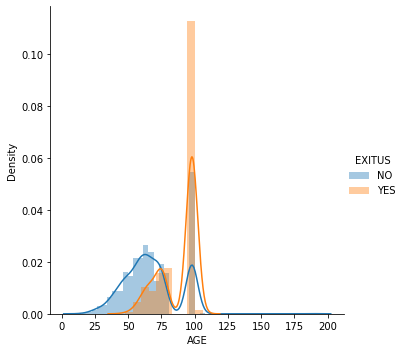

In [126]:
sns.FacetGrid(df, hue ="EXITUS", size=5).map(sns.distplot, "AGE").add_legend()

In [127]:
df.AGE.value_counts()

98.0     574
77.0     140
74.0     105
72.0      94
57.0      77
        ... 
15.0       1
106.0      1
105.0      1
18.0       1
102.0      1
Name: AGE, Length: 62, dtype: int64

Since there are many values of success in the age of around 100, in particular 98, which does not make much sense, these values are eliminated

In [128]:
df = df[df["AGE"]<98]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWar

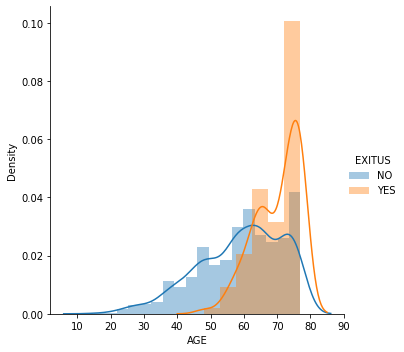

In [129]:
sns.FacetGrid(df, hue ="EXITUS", size=5).map(sns.distplot, "AGE").add_legend()

In [130]:

"""
var = ["DAYS_HOSPITAL","DAYS_ICU","TEMP","HEART_RATE","gl","SAT_O2","BLOOD_PRES_SYS","BLOOD_PRES_DIAS"]
for elem in var:
    g = sns.FacetGrid(df, hue ="EXITUS", size=5)
    g.map(sns.distplot, elem)
    g.add_legend()  
"""

'\nvar = ["DAYS_HOSPITAL","DAYS_ICU","TEMP","HEART_RATE","gl","SAT_O2","BLOOD_PRES_SYS","BLOOD_PRES_DIAS"]\nfor elem in var:\n    g = sns.FacetGrid(df, hue ="EXITUS", size=5)\n    g.map(sns.distplot, elem)\n    g.add_legend()  \n'

### Multivariate Analysis:

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


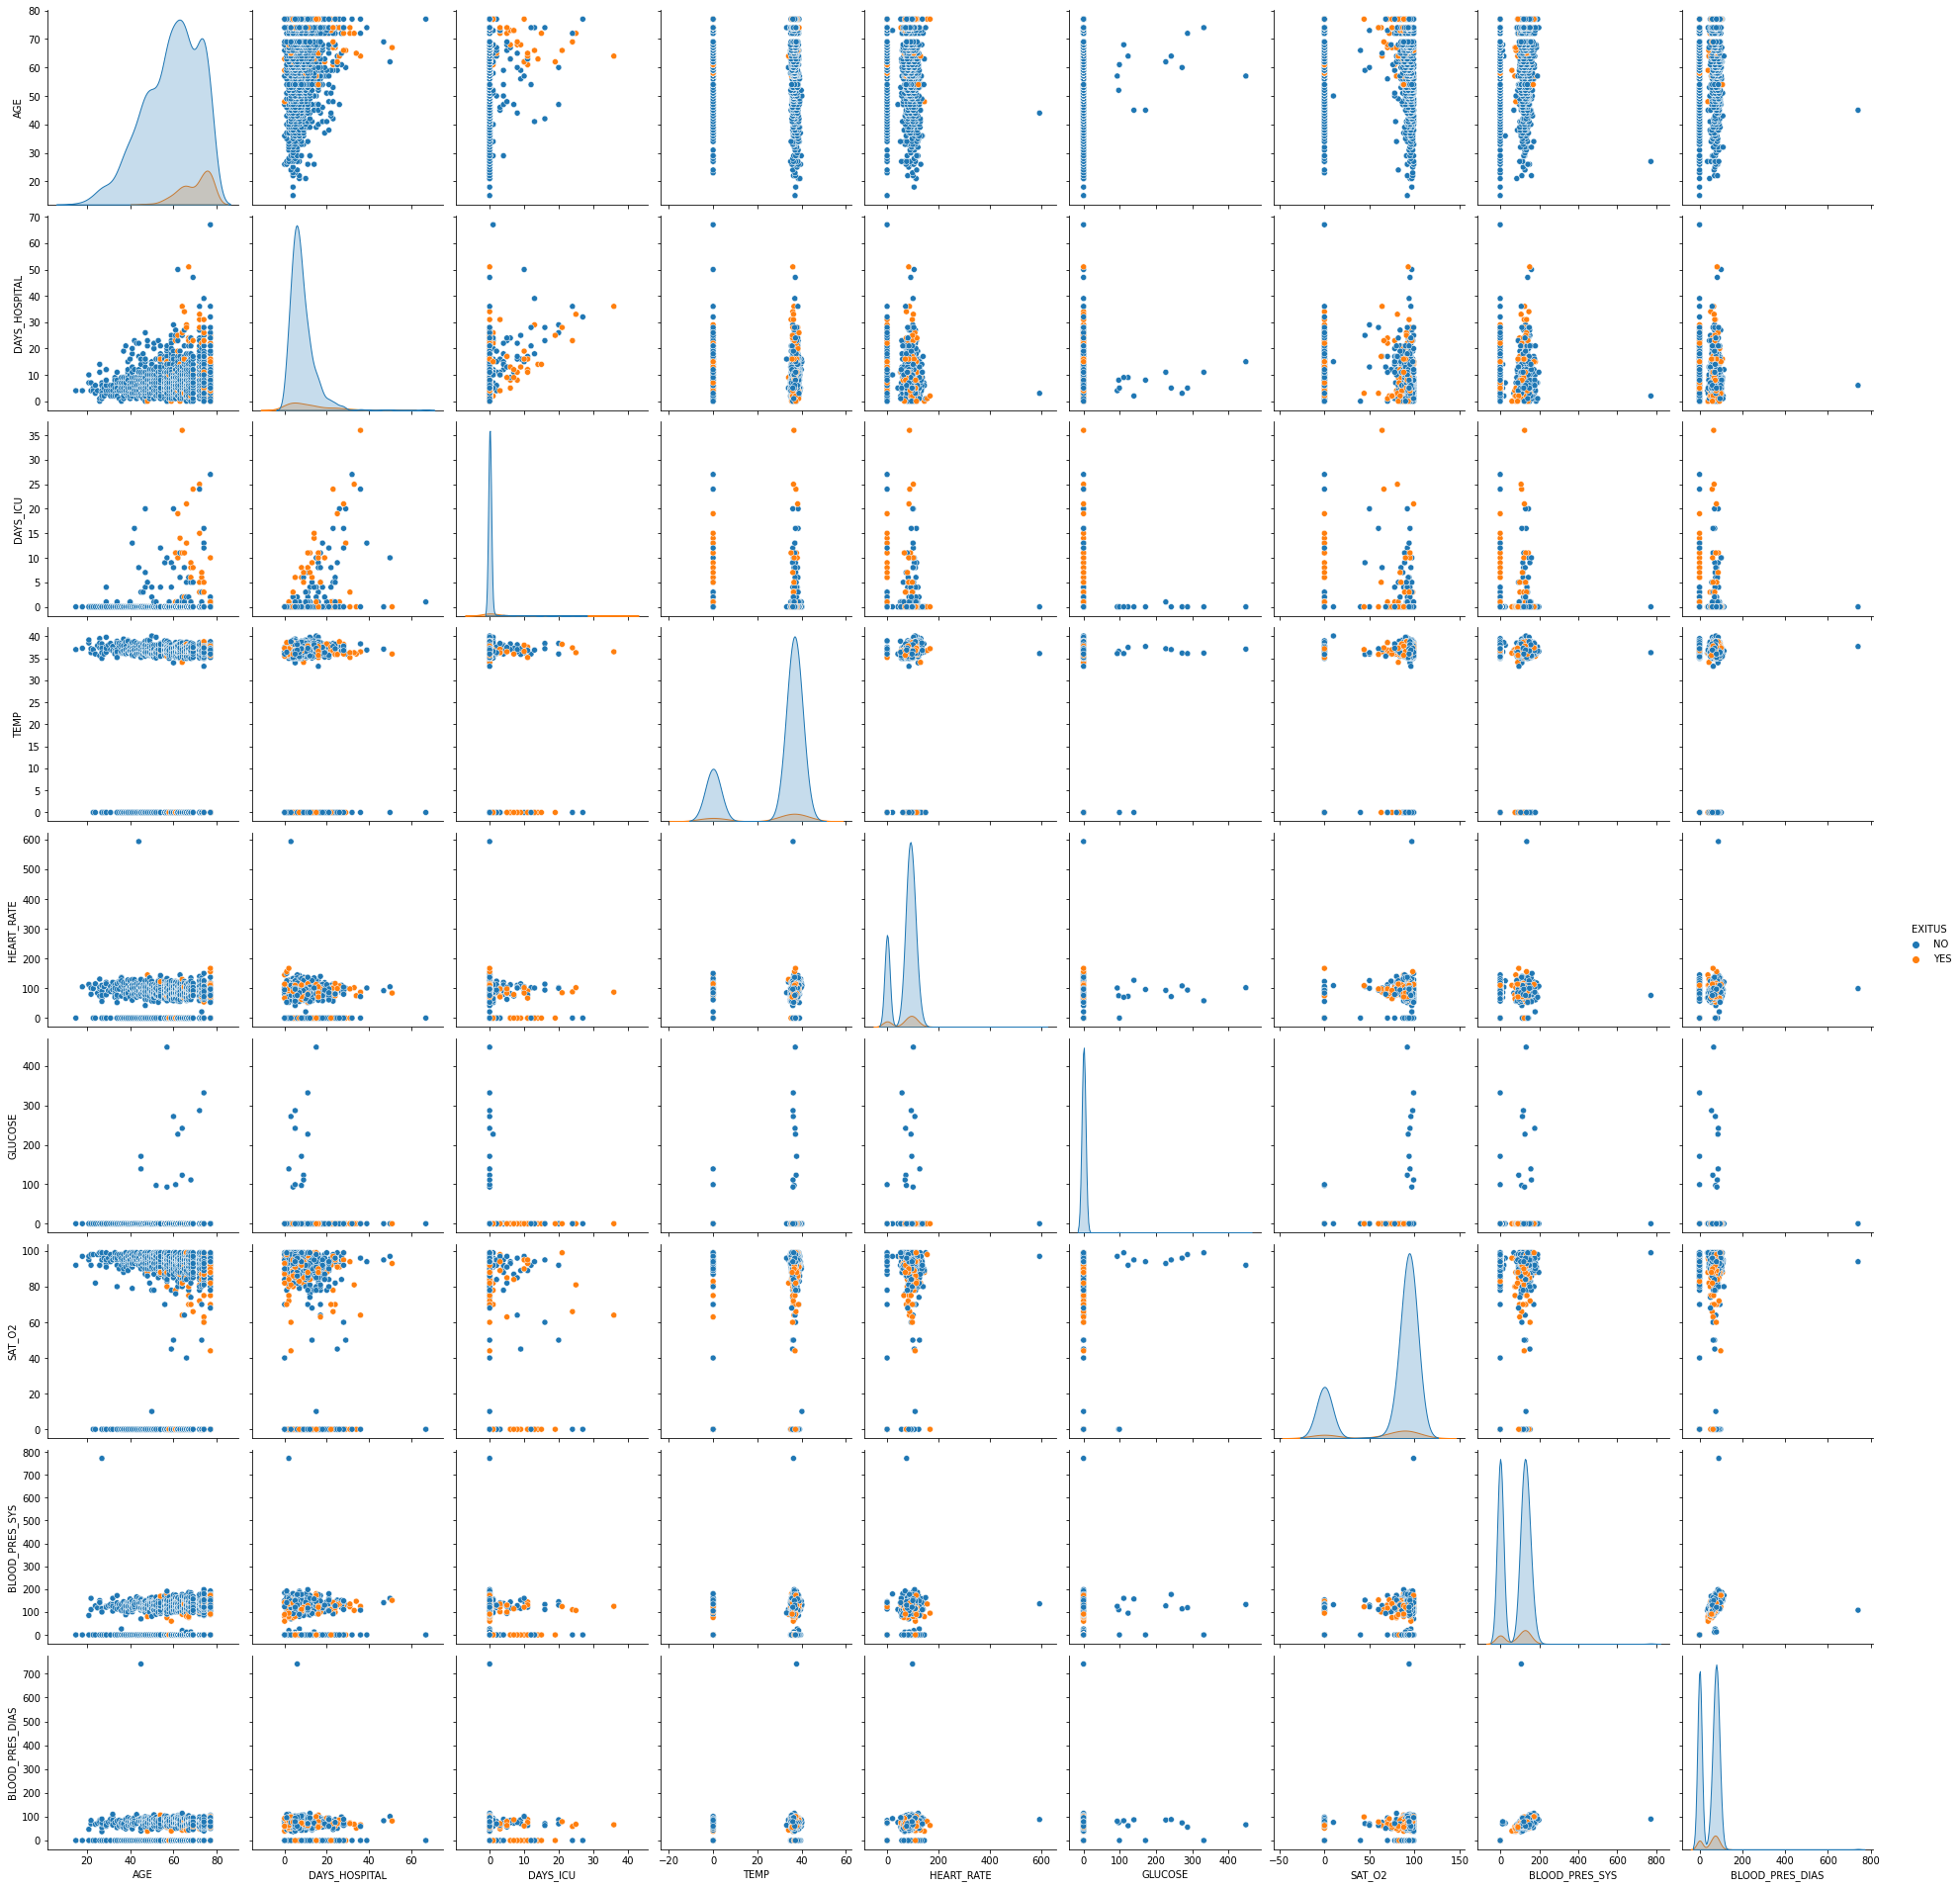

In [131]:
#pairplot
sns.pairplot(df, hue="EXITUS",size =3) 
plt.show()

## Preprocessing

### Make all columns numeric 

In [132]:
df.dtypes

AGE                float64
SEX                 object
DAYS_HOSPITAL        int64
DAYS_ICU             int64
EXITUS              object
DESTINATION         object
TEMP               float64
HEART_RATE           int64
GLUCOSE              int64
SAT_O2               int64
BLOOD_PRES_SYS       int64
BLOOD_PRES_DIAS      int64
dtype: object

### Null values

In [133]:
df.isnull().sum() 

AGE                  0
SEX                  2
DAYS_HOSPITAL        0
DAYS_ICU             0
EXITUS              30
DESTINATION        970
TEMP                 0
HEART_RATE           0
GLUCOSE              0
SAT_O2               0
BLOOD_PRES_SYS       0
BLOOD_PRES_DIAS      0
dtype: int64

#### DESTINATION

In [134]:
df.DESTINATION.value_counts()

ADMISSION    495
Name: DESTINATION, dtype: int64

In [135]:
df.DESTINATION =  df.DESTINATION.fillna(0)
df.DESTINATION = df.DESTINATION.replace('ADMISSION',1)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Values of the variable EXITUS that are null are eliminated, since it is the variable to be predicted. 

In [136]:
df = df[df['EXITUS'].notna()]

#### Rest of variables 
Since the number of null elements in the rest of the variables is very small, these have the mean value.  

In [137]:
df['AGE'] = df['AGE'].fillna(df['AGE'].mean())
df['SEX'] = df['SEX'].fillna(df['SEX'].mode()[0])

df.isnull().sum() 

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


AGE                0
SEX                0
DAYS_HOSPITAL      0
DAYS_ICU           0
EXITUS             0
DESTINATION        0
TEMP               0
HEART_RATE         0
GLUCOSE            0
SAT_O2             0
BLOOD_PRES_SYS     0
BLOOD_PRES_DIAS    0
dtype: int64

In [138]:
df.SEX.mode()

0    MALE
dtype: object

### Make categorical variables to numerical for the analisys

In [139]:
print(df.EXITUS.value_counts())
df.EXITUS = df.EXITUS.replace('NO',0)
df.EXITUS = df.EXITUS.replace('YES',1)

NO     1324
YES     111
Name: EXITUS, dtype: int64


In [140]:
print(df.SEX.value_counts())
df.SEX = df.SEX.replace('MALE',0)
df.SEX = df.SEX.replace('FEMALE',1)

MALE      910
FEMALE    525
Name: SEX, dtype: int64


## continuation of the analysis 

### survival curves

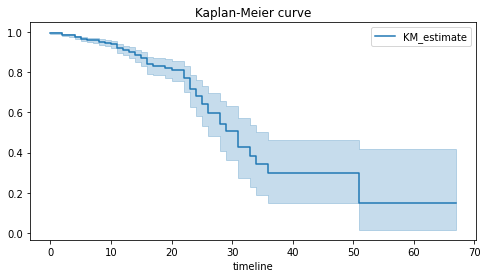

In [141]:
kmf = KaplanMeierFitter() 
kmf.fit(df['DAYS_HOSPITAL'], df['EXITUS'])
plt.figure(figsize=(8,4))
kmf.plot()
plt.title("Kaplan-Meier curve");

### correlation matrix

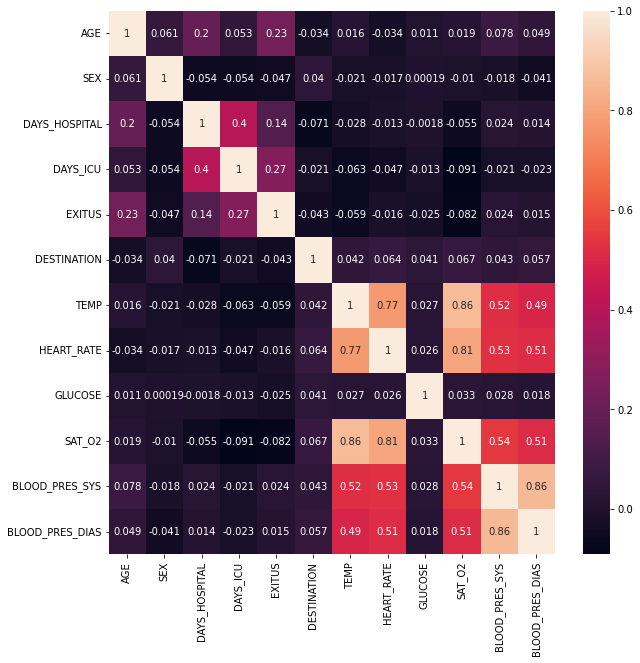

In [142]:
corrMatrix = df.corr()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corrMatrix, annot=True,  ax=ax)
plt.show()

### Dataset normalization

In [143]:
Y = df.EXITUS

In [144]:

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import make_column_transformer

X = df.drop(['EXITUS'], axis=1)

col_transformer = make_column_transformer(
    (OneHotEncoder(), ['SEX', 'DESTINATION']), 
    (MinMaxScaler(), ['AGE', 'DAYS_HOSPITAL', 'DAYS_ICU', 'TEMP', 'HEART_RATE', 'GLUCOSE', 'SAT_O2', 'BLOOD_PRES_SYS', 'BLOOD_PRES_DIAS']))

X = col_transformer.fit_transform(X)

In [145]:
X = pd.DataFrame(data=X)


# Clasification

In [146]:
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=4815)

### Regresión logistica 

In [147]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

LL = LogisticRegression()
LL.fit(X_train,y_train)
Y_pred_test = LL.predict(X_test)  
print(metrics.confusion_matrix(y_test,Y_pred_test))
print( "Accuracy : " + str(np.round(metrics.accuracy_score(y_test,Y_pred_test),3)))
print( "Precision : " + str(np.round(metrics.precision_score(y_test,Y_pred_test),3)))
print( "Recall : " + str(np.round(metrics.recall_score(y_test,Y_pred_test),3)))
print( "F1 : " + str(np.round(metrics.f1_score(y_test,Y_pred_test),3)))

[[394   1]
 [ 36   0]]
Accuracy : 0.914
Precision : 0.0
Recall : 0.0
F1 : 0.0


### Decission Tree

In [148]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier


param_dtree = {}
param_dtree ['max_depth'] = [3, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 125, 150]

grid_dtree = GridSearchCV( DecisionTreeClassifier(), param_dtree, scoring='accuracy', cv=5, n_jobs=-1)
grid_dtree.fit(X_train, y_train)

results = pd.DataFrame(grid_dtree.cv_results_)[['params', 'mean_test_score', 'rank_test_score']]
results

,params,mean_test_score,rank_test_score
0,{'max_depth': 3},0.923313,1
1,{'max_depth': 5},0.920328,2
2,{'max_depth': 10},0.910358,3
3,{'max_depth': 20},0.899393,10
4,{'max_depth': 30},0.898408,11
5,{'max_depth': 40},0.899403,8
6,{'max_depth': 50},0.901393,6
7,{'max_depth': 60},0.898408,11
8,{'max_depth': 70},0.898398,13
9,{'max_depth': 80},0.899398,9


In [149]:
clf = DecisionTreeClassifier( max_depth=3)
clf = clf.fit(X_train,y_train)

print(metrics.confusion_matrix(y_test,clf.predict(X_test)))
print("Accuracy: " + str(np.round(metrics.accuracy_score(y_test, clf.predict(X_test)),3)))
print("Precision: " + str(np.round(metrics.precision_score(y_test, clf.predict(X_test)),3)))
print("Recall: " + str(np.round(metrics.recall_score(y_test, clf.predict(X_test)),3)))
print("F1: " + str(np.round(metrics.f1_score(y_test, clf.predict(X_test)),3)))

[[389   6]
 [ 27   9]]
Accuracy: 0.923
Precision: 0.6
Recall: 0.25
F1: 0.353


### SVM

In [150]:
from sklearn.svm import SVC
SVM_res = SVC()
SVM_res.fit(X_train, y_train);
Y_pred = SVM_res.predict(X_test)
print(metrics.confusion_matrix(y_test,Y_pred))
print( "Accuracy : " + str(np.round(metrics.accuracy_score(y_test,Y_pred),3)))
print( "Precision : " + str(np.round(metrics.precision_score(y_test,Y_pred),3)))
print( "Recall : " + str(np.round(metrics.recall_score(y_test,Y_pred),3)))
print( "F1 : " + str(np.round(metrics.f1_score(y_test,Y_pred),3)))

[[395   0]
 [ 36   0]]
Accuracy : 0.916
Precision : 0.0
Recall : 0.0
F1 : 0.0


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### KNN

In [151]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
    
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train);
Y_pred = knn.predict(X_test)
    
print(metrics.confusion_matrix(y_test,Y_pred))
print( "Accuracy : " + str(np.round(metrics.accuracy_score(y_test,Y_pred),3)))
print( "Precision : " + str(np.round(metrics.precision_score(y_test,Y_pred),3)))
print( "Recall : " + str(np.round(metrics.recall_score(y_test,Y_pred),3)))
print( "F1 : " + str(np.round(metrics.f1_score(y_test,Y_pred),3)))

[[389   6]
 [ 28   8]]
Accuracy : 0.921
Precision : 0.571
Recall : 0.222
F1 : 0.32


### Redes neuronales

In [152]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import backend as K
import numpy as np
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

In [153]:
EPOCHS = 20
def plot(h):
    LOSS = 0; ACCURACY=1
    training= np.zeros((2,EPOCHS)); testing= np.zeros((2, EPOCHS))
    training[LOSS]= h.history['loss']
    testing[LOSS]= h.history['val_loss']

    training[ACCURACY]= h.history['accuracy']
    testing[ACCURACY]= h.history['val_accuracy']

    epochs= range(1, EPOCHS+1)
    fig, axs = plt.subplots(1, 2, figsize=(17,5))
    for i, label in zip((LOSS, ACCURACY), ('loss', 'accuracy')):
      axs[i].plot(epochs, training[i], 'b-', label='Training ' + label)
      axs[i].plot(epochs, testing[i], 'y-', label='Test ' + label)
      axs[i].set_title('Training and Test '+ label)
      axs[i].set_xlabel('Epochs')
      axs[i].set_ylabel(label)
      axs[i].legend()
    plt.show()

In [154]:
model = Sequential() 
model.add(Dense(50,input_dim = X_train.shape[1],activation='relu')) 
model.add(Dense(20,activation='relu')) 
model.add(Dense(5,activation='relu')) 
model.add(Dense(1,activation='sigmoid'))
print(model.summary())
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=EPOCHS, batch_size=520, verbose=1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 50)                700       
_________________________________________________________________
dense_5 (Dense)              (None, 20)                1020      
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 105       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 6         
Total params: 1,831
Trainable params: 1,831
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
2/2 [==============================] - 1s 299ms/step - loss: 0.7627 - accuracy: 0.0747 - val_loss: 0.7482 - val_accuracy: 0.0835
Epoch 2/20
2/2 [==============================] - 0s 44ms/step - loss: 0.7426 - accuracy: 0.0747 - val_lo

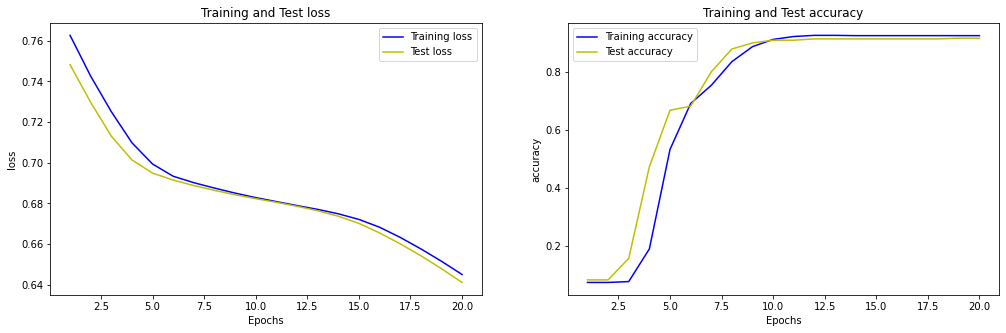

In [155]:
plot(history) 

## Same element number  

In [156]:
print(df.EXITUS.value_counts())


0    1324
1     111
Name: EXITUS, dtype: int64


In [166]:
from sklearn.utils import shuffle

dfreduced = df[df.EXITUS == 0].sample(111) 
dfreduced = pd.concat([dfreduced, df[df.EXITUS == 1]])
dfreduced = shuffle(dfreduced)

,AGE,SEX,DAYS_HOSPITAL,DAYS_ICU,EXITUS,DESTINATION,TEMP,HEART_RATE,GLUCOSE,SAT_O2,BLOOD_PRES_SYS,BLOOD_PRES_DIAS
ID,,,,,,,,,,,,
770,63.0,0,8,6,1,0,0.0,0,0,0,0,0
1203,73.0,0,4,0,1,1,36.2,93,0,87,123,78
905,65.0,1,3,0,1,0,36.4,104,0,91,135,85
1461,77.0,0,16,0,1,1,35.7,71,0,88,91,56
458,56.0,0,3,0,0,0,35.9,88,0,95,123,89
...,...,...,...,...,...,...,...,...,...,...,...,...
889,65.0,0,4,2,1,0,0.0,0,0,0,0,0
1382,77.0,0,6,0,1,1,37.3,93,0,94,138,64
616,59.0,0,1,0,0,0,36.0,85,0,93,103,80


In [167]:
Y2 = dfreduced.EXITUS

In [168]:

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import make_column_transformer

X2 = dfreduced.drop(['EXITUS'], axis=1)

col_transformer = make_column_transformer(
    (OneHotEncoder(), ['SEX', 'DESTINATION']), 
    (MinMaxScaler(), ['AGE', 'DAYS_HOSPITAL', 'DAYS_ICU', 'TEMP', 'HEART_RATE', 'GLUCOSE', 'SAT_O2', 'BLOOD_PRES_SYS', 'BLOOD_PRES_DIAS']))

X2 = col_transformer.fit_transform(X2)

In [169]:
X2 = pd.DataFrame(data=X2)

In [170]:
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X2, Y2, test_size=0.3, random_state=4815)

### Regresión logistica 

### Decission Tree

In [171]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier


param_dtree = {}
param_dtree ['max_depth'] = [3, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 125, 150]

grid_dtree = GridSearchCV( DecisionTreeClassifier(), param_dtree, scoring='accuracy', cv=5, n_jobs=-1)
grid_dtree.fit(X_train, y_train)

results = pd.DataFrame(grid_dtree.cv_results_)[['params', 'mean_test_score', 'rank_test_score']]
results

,params,mean_test_score,rank_test_score
0,{'max_depth': 3},0.761290,1
1,{'max_depth': 5},0.729032,9
2,{'max_depth': 10},0.722581,13
3,{'max_depth': 20},0.741935,6
4,{'max_depth': 30},0.754839,2
5,{'max_depth': 40},0.716129,14
6,{'max_depth': 50},0.729032,9
7,{'max_depth': 60},0.748387,4
8,{'max_depth': 70},0.729032,9
9,{'max_depth': 80},0.729032,9


In [172]:
clf = DecisionTreeClassifier( max_depth=3)
clf = clf.fit(X_train,y_train)

print(metrics.confusion_matrix(y_test,clf.predict(X_test)))
print("Accuracy: " + str(np.round(metrics.accuracy_score(y_test, clf.predict(X_test)),3)))
print("Precision: " + str(np.round(metrics.precision_score(y_test, clf.predict(X_test)),3)))
print("Recall: " + str(np.round(metrics.recall_score(y_test, clf.predict(X_test)),3)))
print("F1: " + str(np.round(metrics.f1_score(y_test, clf.predict(X_test)),3)))

[[27  5]
 [ 9 26]]
Accuracy: 0.791
Precision: 0.839
Recall: 0.743
F1: 0.788


### SVM

In [173]:
from sklearn.svm import SVC
SVM_res = SVC()
SVM_res.fit(X_train, y_train);
Y_pred = SVM_res.predict(X_test)
print(metrics.confusion_matrix(y_test,Y_pred))
print( "Accuracy : " + str(np.round(metrics.accuracy_score(y_test,Y_pred),3)))
print( "Precision : " + str(np.round(metrics.precision_score(y_test,Y_pred),3)))
print( "Recall : " + str(np.round(metrics.recall_score(y_test,Y_pred),3)))
print( "F1 : " + str(np.round(metrics.f1_score(y_test,Y_pred),3)))

[[27  5]
 [ 5 30]]
Accuracy : 0.851
Precision : 0.857
Recall : 0.857
F1 : 0.857


### KNN

In [174]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
    
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train);
Y_pred = knn.predict(X_test)
    
print(metrics.confusion_matrix(y_test,Y_pred))
print( "Accuracy : " + str(np.round(metrics.accuracy_score(y_test,Y_pred),3)))
print( "Precision : " + str(np.round(metrics.precision_score(y_test,Y_pred),3)))
print( "Recall : " + str(np.round(metrics.recall_score(y_test,Y_pred),3)))
print( "F1 : " + str(np.round(metrics.f1_score(y_test,Y_pred),3)))

[[28  4]
 [10 25]]
Accuracy : 0.791
Precision : 0.862
Recall : 0.714
F1 : 0.781


### Redes neuronales

In [176]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import backend as K
import numpy as np
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

In [177]:
EPOCHS = 20
def plot(h):
    LOSS = 0; ACCURACY=1
    training= np.zeros((2,EPOCHS)); testing= np.zeros((2, EPOCHS))
    training[LOSS]= h.history['loss']
    testing[LOSS]= h.history['val_loss']

    training[ACCURACY]= h.history['accuracy']
    testing[ACCURACY]= h.history['val_accuracy']

    epochs= range(1, EPOCHS+1)
    fig, axs = plt.subplots(1, 2, figsize=(17,5))
    for i, label in zip((LOSS, ACCURACY), ('loss', 'accuracy')):
      axs[i].plot(epochs, training[i], 'b-', label='Training ' + label)
      axs[i].plot(epochs, testing[i], 'y-', label='Test ' + label)
      axs[i].set_title('Training and Test '+ label)
      axs[i].set_xlabel('Epochs')
      axs[i].set_ylabel(label)
      axs[i].legend()
    plt.show()

In [178]:
model = Sequential() 
model.add(Dense(50,input_dim = X_train.shape[1],activation='relu')) 
model.add(Dense(20,activation='relu')) 
model.add(Dense(5,activation='relu')) 
model.add(Dense(1,activation='sigmoid'))
print(model.summary())
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=EPOCHS, batch_size=520, verbose=1)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 50)                700       
_________________________________________________________________
dense_9 (Dense)              (None, 20)                1020      
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 105       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 6         
Total params: 1,831
Trainable params: 1,831
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
1/1 [==============================] - 4s 4s/step - loss: 0.7094 - accuracy: 0.5097 - val_loss: 0.7118 - val_accuracy: 0.4776
Epoch 2/20
1/1 [==============================] - 0s 84ms/step - loss: 0.7038 - accuracy: 0.5097 - val_loss:

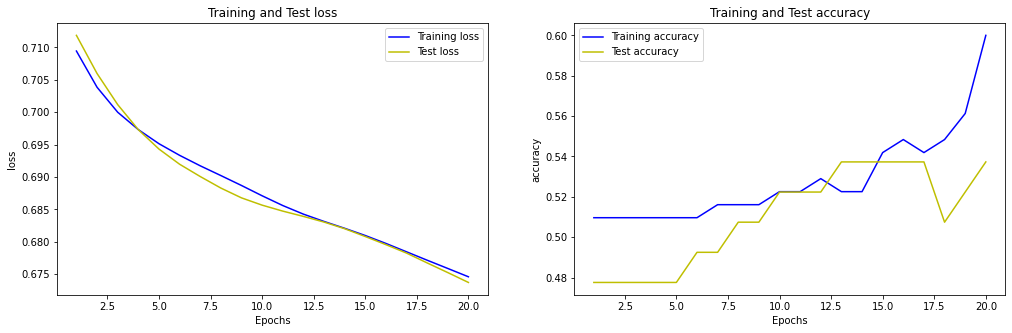

In [179]:
plot(history) 